In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False
FIGSIZE = (12, 7)

# Section 10: Introduction

In this lesson, we'll imagine we are working in the data science team of an e-commerce company. In particular, we sell really good and fresh fish to our clients (mainly fancy restaurants).

Lol! Does it sound familiar?

* Of course! We're in a very similar setting than in the previous lesson
* But it's for a good reason!

In the previous lesson, we worked following these steps:

* Exploratory Data Analysis
* Planning
* Model development
    * Propose model
    * Fit model
    * Evaluate fit
    * Inspect inferences
* Insight extraction & communication

Today, we're focusing on Model development only, because we're learning how to use a fantastic new tool: Bambi

# Section 20: The world's simplest model, now simpler

## First things first

In [3]:
data = pd.read_csv("data/fish-market.csv")
data = data[data["Weight"] > 0].reset_index(drop=True)
data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
153,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
154,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
155,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
156,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


Let's quickly load the data frame and remove the observation with the null weight.

## Intercept only model

$$
\begin{aligned}
\text{Weight}_i &= \beta_0 + \varepsilon_i \\
\varepsilon_i & \sim \text{Normal}(0, \sigma) 
\end{aligned}
$$

In [4]:
model = bmb.Model("Weight ~ 1", data)

Let's create the intercept only model using Bambi. As you can see, it fits in a single line. We only need to pass a formula describing the model and the data frame with the data. We'll come back to the details in just a moment.

## Fit

In [5]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Weight_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


Yes, it's that simple. How cool is that? No need to miss you beloved scikit-learn API anymore. Bambi brings back the nice `.fit()` method. 

And something else, doesn't the sampler message look familiar to you? It's because Bambi is working with a PyMC model under the hood! So whenever we fit a Bambi model, we're actually fitting a PyMC one!

## What's in the returned object?

In [6]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

As PyMC does, Bambi also returns an `InferenceData`. It contains similar information than the `InferenceData` objects we obtain when working with PyMC models directly. We have the following groups

* posterior: Draws from the posterior distribution
* log_likelihood: The log likelihood evaluated at every draw of the posterior
* sample_stats: Statistics of the sampler 
* observed_data: The fish weights

We're mostly interested in the posterior for now. 

## The posterior

In [7]:
idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 2, draw: 1000)
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    Intercept     (chain, draw) float64 412.9 399.7 415.4 ... 394.3 378.1 383.7
    Weight_sigma  (chain, draw) float64 359.6 361.8 353.1 ... 370.8 370.1 370.3
Attributes:
    created_at:                  2022-11-25T18:40:45.649483
    arviz_version:               0.12.1
    inference_library:           pymc
    inference_library_version:   4.1.5
    sampling_time:               3.6689748764038086
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1

$$
\begin{aligned}
\beta_0 & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\text{Weight}_i & \sim \text{Normal}(\beta_0, \sigma) 
\end{aligned}
$$

There are two parameters: one called Intercept and other called Weight_sigma. If we have a second look at the distributional representation of the model, we can see they match $\beta_0$ and $\sigma$.

## It's simply InferenceData

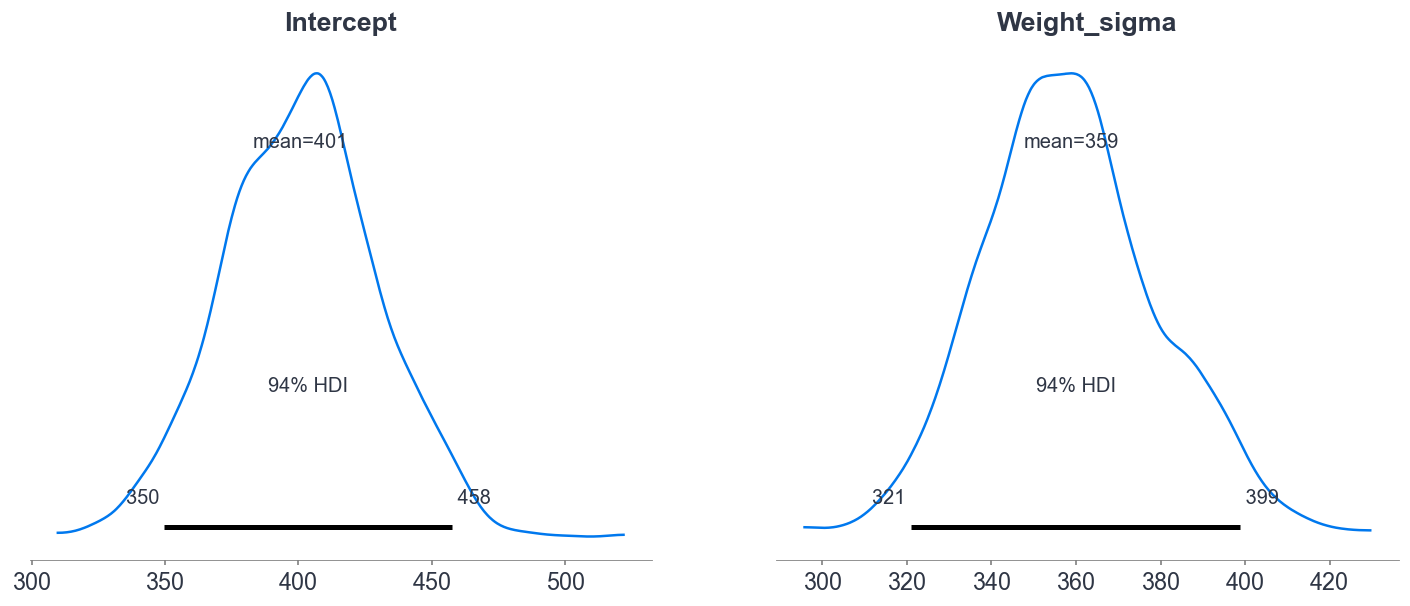

In [8]:
az.plot_posterior(idata);

It's ArviZ friendly. We can use all the ArviZ functions we love using with PyMC models. It's the same type of object, so expect to be able to to the same!

Let's have a look at the marginal posteriors now. Does it look familiar? Does it match the values we got in our previous lesson? 

* The posterior of the Intercept is very similar, it's just a little wider
* The posterior of Sigma is around larger values. Looks like the priors we had for the PyMC model were more restrictive than the priors here.

## What did we do?

* We created a Bambi model
* It's a one liner

The basics of a Bambi model are

* A model formula
    * The specification of the response and predictors
* A data frame
    * Where we extract variables from

**Note:** I would like to create a visual representation (with draw.io)

## How formulas are translated to models

<center>
  <img src="imgs/formula_1.png" style="width:40%"; />
</center>

The model formula is a concise and clear representation of the response and the predictors of a statistical model. One of it's main characteristics is the tilde operator (`~`). It separates the response from the predictors. Anything on left hand side is part of the response, and anything on the right hand side is part of the predictors.

In this lesson we're going to cover many details about the predictors part of the formula. But we have already covered something special! The "1" on the right hand side is not the name of any predictor, right? However, this is how you tell Bambi that you want an intercept.

Along the entire lesson we'll be seeing diagrams like this one, showing how the model formula is translated to the statistical model.

**Optional?**

If you want to understand why it's the one, you can think of it as a predictor that is always equal to one. In the end, multiplying a coefficient by 1 is not going to change it, and that's exactly what happens with the intercept. 

## Comparison with the PyMC model

In [9]:
with pm.Model() as pm_model:
    intercept = pm.Normal("Intercept", sigma=200)
    sigma = pm.HalfNormal("sigma", sigma=100)
    pm.Normal("Weight", mu=intercept, sigma=sigma, observed=data["Weight"])

In [10]:
bmb_model = bmb.Model("Weight ~ 1", data)

* PyMC: 4 lines
* Bambi: 1 line

That's a huge difference!

## Section Recap

* We've introduced Bambi
* Bambi models are made of two basic components
    * A formula
    * A data frame
* Under the hood, it's just a PyMC model
* Benefits of Bambi
    * Concise syntax
    * Allows faster iteration

Bambi takes care of all the complicated internal details.

## Section 30: What's in a Bambi model

In the previous section we saw it's very easy to create models with Bambi. But, being honest, we know very little about these details. The goal of this section is to get more familiar with the components of a Bambi model so we can feel more comfortable when working with them.

## Is Bambi a Bayesian library?

* Bayes in a nutshell: Update prior knowledge with data to obtain a posterior

* Where are the priors in Bambi?

* Bambi provides automatic priors

* Benefits:
    * Faster prototyping
    * Faster iteration
    * Easier to learn

* We still must take care of priors in any serious work

First things first. We created a model and that's great. But if Bambi is a Bayesian library, there must be priors somewhere. And we never wrote them down. I feels like cheating. Why is that? Is it because it's non Bayesian? 

The answer is Bambi is Bayesian, but it provides automatic priors so you it's not strictly required to tell it priors manually. This is a huge topic itself, so this section will show you only the basics. More advanced stuff is going to be covered in much more in an appendix in the end of the lesson. For now, it's good to know that Bambi does follow the Bayesian approach, but it just makes it a little easier for us so we can iterate faster and write less code. Obviously, once we get to use it more seriously, it will be good to specify our own priors.

## Print the model

In [11]:
model = bmb.Model("Weight ~ 1", data)

In [12]:
model

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Previously, we created an intercept-only regression model using Bambi. We saw it was very concise piece of code. Fitting the model was also so easy. But there's something even cooler. When we print a Bambi model, it gives us a lot of information. 

Let's have a look at them one by one.

## The formula

In [13]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Just a reminder of the formula that was used to create the model. If you've just created the model one cell above it's not of much value, but it's really useful if you have several models and you want to make sure what's in each of them.

**Edition note:** Higlight the part we're talking about in each slide.

## The family

In [14]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Families are a broad thing in Bambi that represents the type of the model we're working with. We're going to see this so many times from now. In the meantime, we're happy to see it says `"gaussian"`. This means the model is using a Gaussian likelihood function. 

But this is not magic! It's not happening because Bambi is smart enough to read our minds. Since Gaussian linear regressions are so popular, the `"gaussian"` family is the default choice. We're going to cover several examples where we use non-default families in the following lessons. I bet you'll become a pro!

## The link

In [15]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Similarly to families, links, or link functions, is a key concept. Again, we will not cover in depth in this lesson. In some part it's because such a big topic deserves proper attention, and in other part because it's already very well covered in Lesson 4 -- when it's actually used.

In a nutshell, a link is a function or transformation that is applied to the mean of the likelihood function. It may sound complicated, but believe me, Lesson 4 will shed light on this. For now, we're happy to know it says `"identity". It means it doesn't change anything  -- because it applies the identity function!

## Observations

In [16]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Bambi always tells you how many observations entered the model. In some cases, when there are missing values, it's possible the number of observations Bambi is using is smaller than the number of rows in the data frame. So this is what it's useful for. On top of that, it allows to quickly check the number of observations in all cases without having to look back into the original dataframe.

## Priors

In [17]:
model # hide this cell

Formula: Weight ~ 1
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 400.8475, sigma: 891.4101)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 356.564)

Finally, here are the priors! The first thing we can see is priors come in different groups - common-level effects and auxiliary parameters. These groups have a well defined purpose but it's too early to learn about these more advanced topics. They are very well covered later. What we need to learn now is that whenever we want to check what are the priors in the model, we can print it, and Bambi is going to show us the priors.

The most important things are

* The prior for the `Intercept` is a Normal distribution centered around 400, and sigma equals to 891.
* The prior for `sigma`, the standard deviation of the error term, is a `HalfStudenT` distribution with `nu` equals to 4 and sigma equals to 356.

These values were determined **automatically** by Bambi.

How Bambi chooses priors is a very interesting topic, and there's so much work behind it. This is covered in the appendix that you can find in the end of the Lesson.

## Section Recap

* Bambi models contain so much information
* Printing a model shows a summary of it
* The most important pieces of a model are
    * The formula
    * The family
    * The link function
    * The number of observations
    * The priors

# Section 40: Slopes

## Prepare the data

In [18]:
data["log_weight"] = np.log(data["Weight"])
data["log_length"] = np.log(data["Length1"])

Bambi is great. It allows us to write models with a simple formula. But variable names must exist in the data frame where variables are taken from. And no logarithm is already computed in there. 

Before creating the model, we need to compute the logarithm of the weight and the logarithm of the length and store them as new columns. Then we're ready to go!

## Create the model

In [19]:
model = bmb.Model("log_weight ~ 1 + log_length", data)
model

Formula: log_weight ~ 1 + log_length
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 26.3354)
    log_length ~ Normal(mu: 0, sigma: 8.1834)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

## What's the model?

<center>
  <img src="imgs/formula_1_plus_log_length.png" style="width:60%"; />
</center>

* `1` asks the Intercept parameter again, represented with $\beta_0$ above
* `log_length` asks to include the log length variable as predictor
    * Since it's numeric, Bambi adds a slope $\beta_1$ that multiples the predictor `log_length`
    * The dashed line around the rectangle means it represents observed data

## Build the model

In [20]:
model.build()

The construction of a Bambi model has two steps. 

* Creation of the Bambi model
* Creation of the underlying PyMC model

The first step occurs when we create the model with `bmb.Model()`. The second step can occur implicitly or explicitly. If we call `model.fit()`, the PyMC model is going be built implicitly, before the sampling process starts. But sometimes we want to do get other results for which the PyMC model is needed, like creating a plot of the priors or a graphi of the model, before actually fitting the model. For all those cases, we can build the PyMC model explicitly.

## Explore the priors

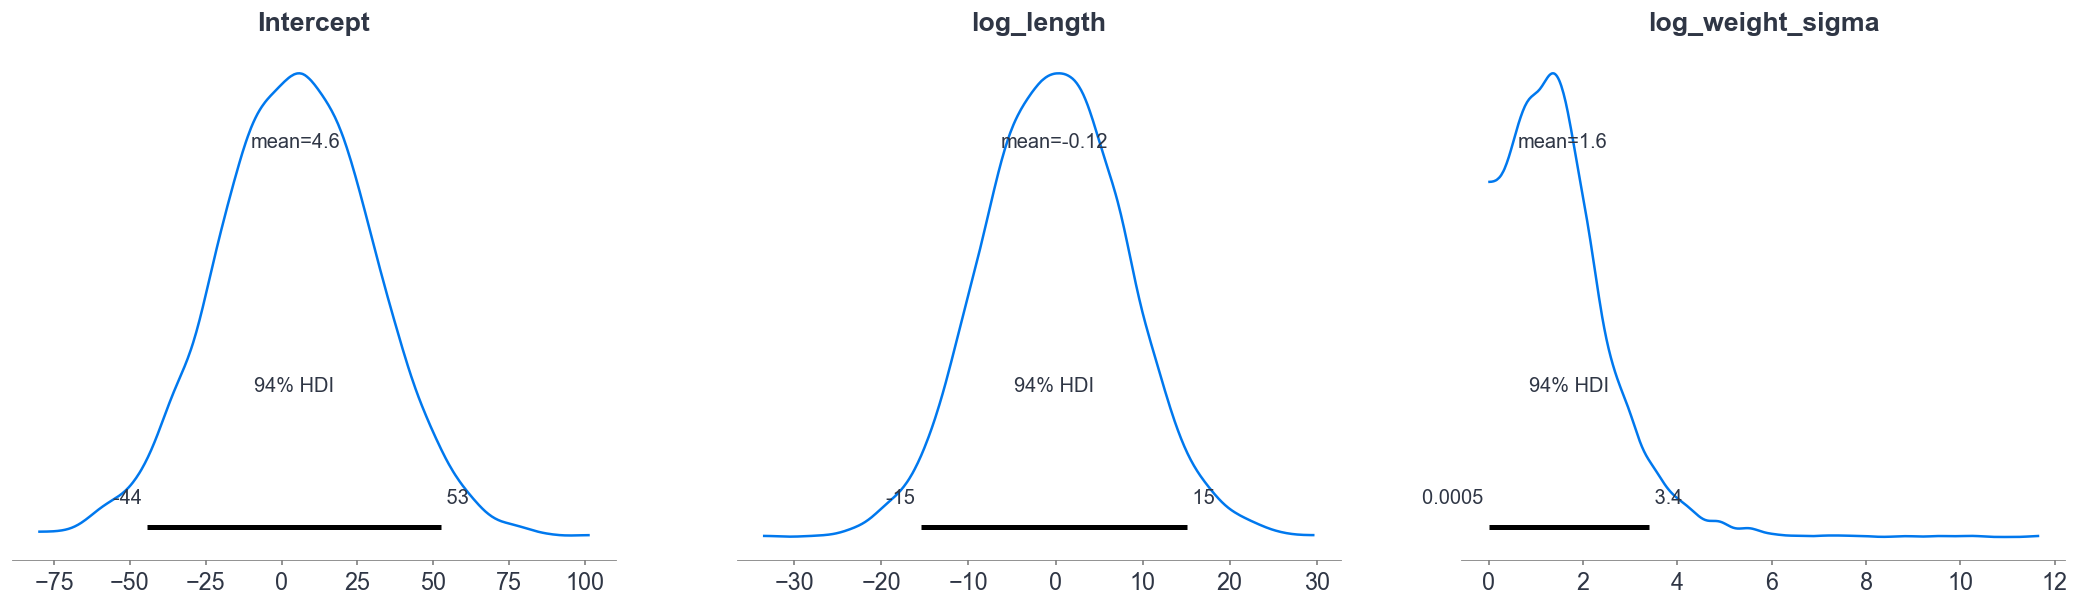

In [21]:
model.plot_priors();

Having built the model, several utilities are made available for us. For example, we can explore the priors of the parameters in the model using a visualization. The only thing we need to do is calling `.plot_priors()` on the model.

Here we see

* The prior for the intercept is centered around 0 and its bulk ranges from -50 to 50
* The prior for the slope is also centered around 0, and most of the probability is between -15 and 15
* And the prior for the scale of the error term is always positive, with its bul between 0 and 4.

**Animation idea:** Highlight the different panels as I interpret them

## Graph

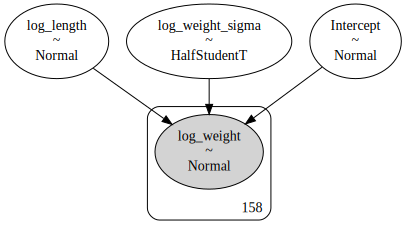

In [22]:
model.graph()

Other of the byproducts is the ability to create a model graph, using plates. It is very common to do something like this with PyMC modelsl, so Bambi offers it for free. All we need to do is is calling the `.graph()` method.

In this case, we see the three parameters are scalar values, there's no number attached to them, and the `log_weight` is the likelihood for which we have 158 observations. 

Obviously this is not the only way one could access this information. Here, we're simply showing the versatility of the library and how you can perform different tasks. The preferred method is a matter of taste and familiarity, and it's up to you.

## Fit the model

In [23]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, log_length, log_weight_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [24]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-4.627,0.239,-5.053,-4.166
log_length,3.144,0.074,2.998,3.275
log_weight_sigma,0.374,0.022,0.333,0.414


There's nothing novel when it comes to fit the model. And that's a good thing actually! It's great not be forced to deal with the intricate things that are happening under the hood. The resulting InferenceData object, `idata`, can be used to obtain insights from the posterior.

* The mean of the posterior of the slope for `log_length` is 3.144, and the HDI ranges from 2.998 to 3.275.
    * The evidence is so clear the longer the fish, the larger the weight
    * But remember, this parameter is in the logarithmic scale! 

## Plot the fitted line

In [25]:
from bambi.plots import plot_cap

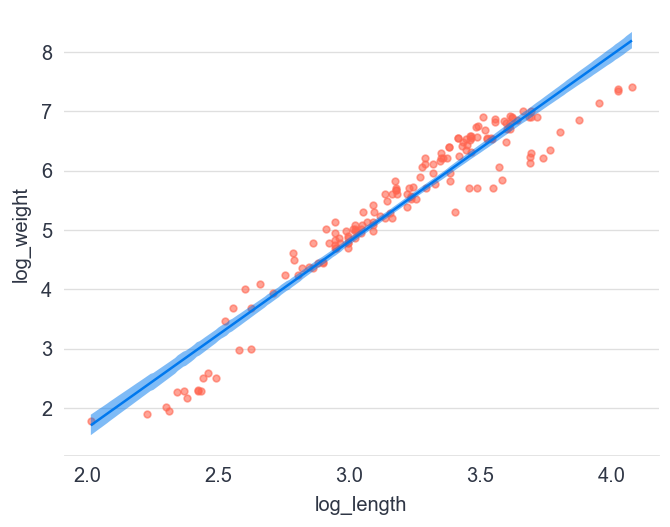

In [26]:
fig, ax = plt.subplots()
ax.scatter(data["log_length"], data["log_weight"], color="C4", alpha=0.6, s=16)
plot_cap(model, idata, "log_length", ax=ax);

## Back in the original scale

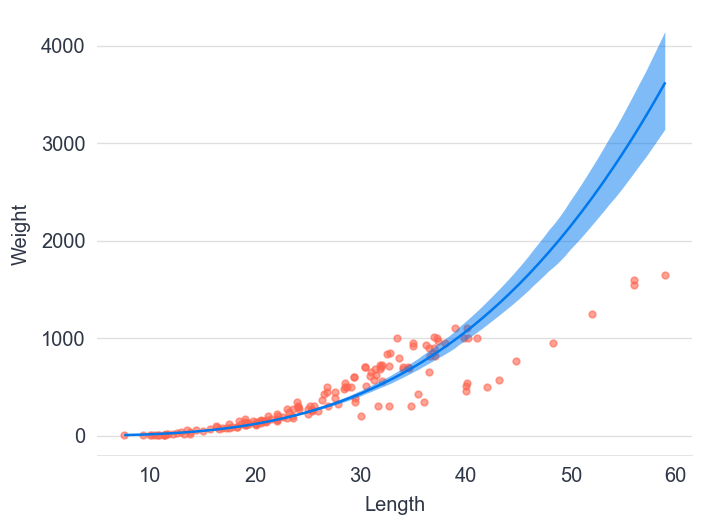

In [28]:
transforms = {"log_length": np.exp, "log_weight": np.exp}
fig, ax = plt.subplots()
ax.scatter(data["Length1"], data["Weight"], color="C4", alpha=0.6, s=16)
plot_cap(model, idata, "log_length", transforms=transforms, ax=ax)
ax.set(xlabel="Length", ylabel="Weight");

## Section Recap

* Saw how many steps of the bayesian workflow were simplified with Bambi from
    * Fitting the single slope model     
    * Checking the priors    
    * Plotting our fitted line with `plot_cap()`
* `plot_cap()` allows visualizing the curve fitted by the model
    * It's easy to use
    * It's versatile  

# Section 50: Transformations in Bambi

## Simplying things even more 

We simplified the model construction by using Bambi. But what if we could simplify even more of our workflow?

## Let's be honest

We don't really need to do

```python
data["f_of_x"] = f(data["x"])
bmb.Model("y ~ f_of_x", data)
```

We can simply do 

```python
bmb.Model("y ~ f(x)", data)
```

I actually lied to you. Lol! 

We don't actually need to transform variables and store them in new columns **before** creating the model. 

Transformations are an extremely important topic. And we mean it! 

It's so important that Bambi allows to use inline transformations. It's so cool!

Instead of having to pre-compute transformations, you can simply use the function within the formula. Bambi knows how to handle it :)

## In our model

In [26]:
model = bmb.Model("log(Weight) ~ 1 + log(Length1)", data)
model

Formula: log(Weight) ~ 1 + log(Length1)
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 26.3354)
    log(Length1) ~ Normal(mu: 0, sigma: 8.1834)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

In [27]:
idata = model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, log(Length1), log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


All that means we can use inline transformations with our model too. Instead of having to precompute the logs, we can simply compute them on the fly within the formula. Bambi knows how to take care of it.

See the inline transformations in action. Do you want transformed variables? It's still one-liner! How cool is that?

## How does it work?

Bambi allows to use two types of transformations

* Functions available in the environment where the model is created
    * Can be a custom function (`fun`) or available in a library (`np.cos` for example)

* Basic built-in functions
    * `log()`
    * `exp()`
    * `abs()`

* Advanced built-in functions
    * `center()`
    * `scale()`

Transformations are functions. Transformations are Python functions. Bambi can use two types of transformations. The first, Python functions that are available in the environment where the model is created. Since we have imported NumPy as `np`, we can access `np.log()`. 

But there's more! Bambi also comes with several built-in transformations that make statistical modeling easier. Sometimes one wants to center the variable (subtract the mean) or scale the variable (subtract the mean and divide by the standard deviation). Instead of having to do it manually, or needing to write our own function, that comes already built-in Bambi.

## Important transformations

* `center(x)`

$$
\text{center}(x) = x - \text{mean}(x)
$$

* `scale(x)`

$$
\text{scale}(x) = \frac{x - \text{mean}(x)}{\text{sd}(x)}
$$

* Explain what they are
* Tell briefly when they're recommended
* Say it's better to let Bambi handle these rather than writing our own functions. Not only because the amount of work, but also because of other complexities.

## Custom operations

* What if I want my predictor 
    * Divided by 10?
    * to the second power?

Don't do this 

```python
"y ~ x / 10"
"y ~ x ** 2"
```

Do this

```python
"y ~ I(x / 10)"
"y ~ I(x ** 2)"
```

or this

```python
"y ~ {x / 10}"
"y ~ {x ** 2}"
```

The operators `/` and `**`, as many other operators, have a different meaning in the formula mini-language.  When we want these operators to have the same meaning they would do in Python (or actually, in regular math!) we have to "escape" them. To do that we can use the `I()` function or brackets. Anything written within them will be evaluated as regular Python. 

## Formulas are so powerful

* The response variable

* The predictors

* Transformations!
    * Of several kinds

simplifies communication, reduces misunderstanding... it's a very powerful tool!

## Section Recap

* Bambi can simplify not only the model but also the data processing steps
* Transformations are one of the most powerful concepts, not just in Regression by ML As a whole
* Bambi supports two types of transforms commonly used by regression practioners
    * There are various transform functions 

# Section 60: Modeling categories

**ADD PICTURE**

## Categorical is not the same as numeric

* Length, Width, and Height are numeric
    * Math makes total sense

* Species is categorical
    * Math does not make sense

* We need to treat categorical variables in a different way
    * We did it with PyMC in the previous lesson
    * Split the line into multiple lines

All the body measures of the fish are numeric, and thus regular math makes total sense. We can add the length of two fish, for example, and the result is a meaningful thing. 

But species is of a different kind. We cannot do the same kind of math with the species of the fish. That's why species has to be treated in a different way when creating our model. And that's what we did in the previous lesson with PyMC -- we added a different intercept and slope for each species. At that time we showed it was the same than splitting the regression line into multiple lines.

## Categorical **is** the same as numeric

* Bambi makes life easier 

* Using categories is the same

* Bambi knows how to handle all the details for us

Bambi is here to make our lives easier. A big part of that is removing all the burden associated with dealing with categorical variables. 

In the previous lesson we saw it required a non-trivial amount of work, and it was just one categorical variable! 

With Bambi, using categorical variables is the same thing as using numeric variables. We simply pass the name of the variable into the model formula. 

## Modeling categories

In [28]:
model_c1 = bmb.Model("log(Weight) ~ 1 + Species", data)
model_c1

Formula: log(Weight) ~ 1 + Species
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 5.41, sigma: 4.6946)
    Species ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [12.9856  6.9091 10.6655 10.1609 11.6298 17.2909])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

* There is no need to perform _any_ data manipulation step

Let's create the model. The response is the logarithm of the `Weight` of the fish, and we have an intercept and the species as predictors. When we print the model, notice the parameters of the prior for the `Species` predictor are arrays. This is because there are multiple species.

Can you spot where we perform data manipulation steps for the species? I bet you can't! 

To create the model in Bambi we don't need to tell it `Species` is of a different kind. Bambi is very smart and is capable of detecting categorical variables and it handles them in an appropriate way.

It's not completely free of any cost, though. It comes together with a couple of tricky details we'll cover in just a moment.

## Fit

In [29]:
idata_c1 = model_c1.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [30]:
np.exp(az.summary(idata_c1)["mean"])

Intercept             581.144828
Species[Parkki]         0.233868
Species[Perch]          0.404542
Species[Pike]           1.001001
Species[Roach]          0.243169
Species[Smelt]          0.018188
Species[Whitefish]      0.796124
log(Weight)_sigma       2.159766
Name: mean, dtype: float64

* Fit the model
    * Very fast, out of the box
* Explore the model coefficients
    * Use the exponential function, so we transform results back to the original scale (we are modeling the log(Weight))
* This opens some questions...

## What's going on?

In [31]:
np.exp(az.summary(idata_c1)["mean"])

Intercept             581.144828
Species[Parkki]         0.233868
Species[Perch]          0.404542
Species[Pike]           1.001001
Species[Roach]          0.243169
Species[Smelt]          0.018188
Species[Whitefish]      0.796124
log(Weight)_sigma       2.159766
Name: mean, dtype: float64

* The dataset has 7 species, but this table shows 6. Why?
* The value of `Intercept` differts a lot from the `Species`. Why?

**Animation note:** 

* Add a number next to the Species parameters so it's easy to see there are 6 of them (like the index of a table)

## Zoom into the formula

<center>
  <img src="imgs/formula_1_plus_species.png" style="width:60%"; />
</center>

To understand what's going on, and why the posterior doesn't show one of the species, we need to understand how the model formula is being mapped onto a statistical model. This is an extremely important part of the course, because it explains complexities of model formulas in deep detail.

The expectation of the response variable, in this case, the log weight, is equal to the sum of two components:

1. An `Intercept` parameter, $\beta_0$, which is the same for all the fish of all species
1. A `Species` parameter, $\beta_{1, j}$
    * This is **not a slope**. It's not multiplying a numeric predictor
    * Think of it as deviations from the intercept specific to each species

## Zoom into the formula: Going deeper

<center>
  <img src="imgs/formula_1_plus_species_extended.png" style="width:60%"; />
</center>

Moving a step forward, we can list all the `Species` parameters. We have 7 species, so these are: $\beta_{1, 1}, \beta_{1, 2}, \cdots, \beta_{1, 7}$. Depending on the value of $j$, which represents the species, we select a different $\beta_1$ parameter. Let's see how it works below.

## The mapping

<center>
  <img src="imgs/expected_values_1_plus_species.png" style="width:45%"; />
</center>

We can write down the expected log weight for every species. We just need to combine $\beta_0$ and the right $\beta_1$ parameter. This way, we can see...

* The mean for the Bream species is $\beta_0 + \beta_{1, 1}$
* The mean for the Parkki species is $\beta_0 + \beta_{1, 2}$
* And so on ... until we reach Whitefish, whose mean is $\beta_0 + \beta_{1, 7}$ 

Let's do another exercise now: count the number of quantities of interest, the mean log weight for each species, and the number of parameters we use to do so. It will help us to detect a problem that is in front of us.

* Starting with Bream, we're interested in estimating one thing, the mean response for the Bream species, and we have two parameters: $\beta_0$ and $beta_{1, 1}$.
* Continuing with Parkki, we have two quantities of interest, and three parameters. $\beta_0$ and $beta_{1, 1}$, and $\beta_{1, 2}$.
* And so on... 
* Until we reach Whitefish. At this point we want to estimate 7 means, and we have 8 parameters.

And that's exactly **the problem**: We have 7 equations and 8 parameters!

* It is a problem with infinite solutions!
    * In other words: the model is non-identifiable.
* How to make the solution unique? **Choose a restriction**
    * And this creates a new problem!
    * Which restriction do we choose?

**Question:** Split narrative in two slides?

**Animation note:** 

* Reveal line by line, up to the second line, then just reval all of them
* In the second round, where we count parameters, have a count of the number of things we want to estimate (the means) and the number of parameters

## Reference encoding (what Bambi does by default)

<center>
  <img src="imgs/formula_1_plus_species_extended_with_zero.png" style="width:60%"; />
</center>

* One solution: Setting one of the coefficients to zero. 
    * This level is known as "reference level" or "pivot category"
* This is like "dropping a level". But actually, it's a little misleading since the level exists, but it's zero.
    * That's why it does not appear in the posterior
* By default, Bambi drops the first level of the categorical variable
    * In this case, it's Bream.
* Now the model is identifiable

## An identified model

<center>
  <img src="imgs/expected_values_1_plus_species_with_zero.png" style="width:45%"; />
</center>

If we go back to the diagram that helped us spot we had 8 parameters and 7 equations and replace the 0 in the right place, we can now see we have 7 parameters and 7 equations. Fixing one parameter to 0 removes one parameter from the system of equations and allows it to have a unique solution, which is what we want.

* Number of things to estimate: 7
* Number of parameters: 7
* The problem has a unique solution! That's great!
* We didn't have to do anything of this by hand. This is the explanation of what's happening and why that's happening.
* Bambi always takes cares of all these details
* With PyMC, we are the ones in charge of taking care of all these details
    * **Ideas**
    * Create a model where we have the intercept and the coefficient for every species without dropping the level and analyze the result
        * It could be an exercise. It will be fun, but it can be frustrating too (how do they know what problems to look for?)

**Note**

* I think some of the notes above can go into the section recap.

## So what...

is the meaning of the `Species` parameters?

<center>
  <img src="imgs/expected_1_plus_species_expanded.png" style="width:50%"; />
</center>

It's clear $\beta_0$ is the mean response for the Bream species, the reference level, because it's the only parameter that appears in that line. But $\beta_0$ is also used in the computation of the mean of all the other species. So what?

All this means the $\beta_{1, j}$ are not the mean values for the different species. They are differences or deflections from the mean of the reference level. Combining both parameters, the mean of the reference level and the deflection for a given species, we obtain the mean of that species.

Is this always the case with coefficients? Nope. It depends on the restriction that is applied to the coefficients. Different will lead to different interpretations. Bambi applies the restriction where you set the coefficient for one  the levels to zero. This is also known as reference encoding.

## It's so complicated... isn't there another solution?

* Bambi made it so easy to create the model, but analyzing the results is so complicated!
* Fortunately, this case allows to use another solution
* Do we really need an intercept term? What's the purpose?
    * Answer: We don't really need the intercept term!
* **Solution:** Remove the intercept parameter!

**Leading question:** If the number of parameters is the same than the number of things we want to estimate. Can't we map parameters and quantities more straightforwardly so parameters have a more interpretable meaning?

Also, we didn't have to think about encodings in PyMC... why? (answer: the PyMC model we built is like the one we show next)

## Remove the intercept

In [32]:
model_c2 = bmb.Model("log(Weight) ~ 0 + Species", data)
model_c2

Formula: log(Weight) ~ 0 + Species
Family name: Gaussian
Link: identity
Observations: 158
Priors:
  Common-level effects
    Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [ 7.9585 12.9856  6.9091 10.6655 10.1609 11.6298 17.2909])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.322)

* For historical reasons, it's not enough to remove the `1` in the formula to remove the intercept
* We need to use a `0` instead of the `1`. 
    * It tells Bambi not to use an intercept term
* All the rest is the same than before

## Fit again

In [33]:
idata_c2 = model_c2.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [34]:
np.exp(az.summary(idata_c2)["mean"])

Species[Bream]        578.246356
Species[Parkki]       137.002613
Species[Perch]        234.393189
Species[Pike]         582.308281
Species[Roach]        140.611392
Species[Smelt]         10.580366
Species[Whitefish]    460.355952
log(Weight)_sigma       2.159766
Name: mean, dtype: float64

* Fitting the model is not the important thing here.
* What matters are the parameters in the model
    * No intercept parameter anymore
    * All species are included now!
* The scale of the `Species` parameter changed a lot from the previous model.
    * Why? Let's figure it out!

## Another solution

<center>
  <img src="imgs/formula_0_plus_species.png" style="width:60%"; />
</center>

* We changed the model formula to remove the intercept
    * We did so including the zero in the formula.
* We kept the `Species`
    * Let's expand it again

## Another solution

<center>
  <img src="imgs/formula_0_plus_species_extended.png" style="width:60%"; />
</center>

* As in the previous case, the mean for a species is the sum of the two components
* But the first component now is 0. So it's actually not there, we don't need to add it.

## Mapping a simpler model

<center>
  <img src="imgs/expected_values_0_plus_species.png" style="width:45%"; />
</center>

* The mapping is so much simpler now!
* 7 quantities to estimate and 7 parameters.

What's even better

* There's a unique solution without having to impose a restriction!
* Parameters have a one-to-one mapping with quantities of interest
    * **Each parameter is the mean of the group!**
    * This is way better!

## Is it a different model?

* Nope
* It's a different parametrization
* Models are equivalent
    * Extract the same conclusions
    * Compute the same predictions

## Don't believe it? Just see

Both models are equivalent!

In [35]:
b_0 = idata_c1.posterior["Intercept"]
b_1j = idata_c1.posterior["Species"].pad({"Species_dim": (1, 0)}, constant_values=0)
b_1j = b_1j.assign_coords({"Species_dim": np.unique(data["Species"])})
species_mean = b_0 + b_1j
species_mean.head({"chain": 1, "draw": 1})

<xarray.DataArray (chain: 1, draw: 1, Species_dim: 7)>
array([[[6.36441051, 4.79323692, 5.43531705, 6.30620524, 5.07982777,
         2.37748141, 6.2300639 ]]])
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0
  * Species_dim  (Species_dim) object 'Bream' 'Parkki' ... 'Smelt' 'Whitefish'

* First we need to compute the sum between the $\beta_0$ and the $\beta_{1, j}$
    * We left pad the species posterior to add the 0 for the first species
    * Then we assign the coordinate values again, since it doesn't have the reference level (Bream)
    * Then simply sum both DaraArrays
* See the result. Now we have the 7 species.

## Don't believe it? Just see

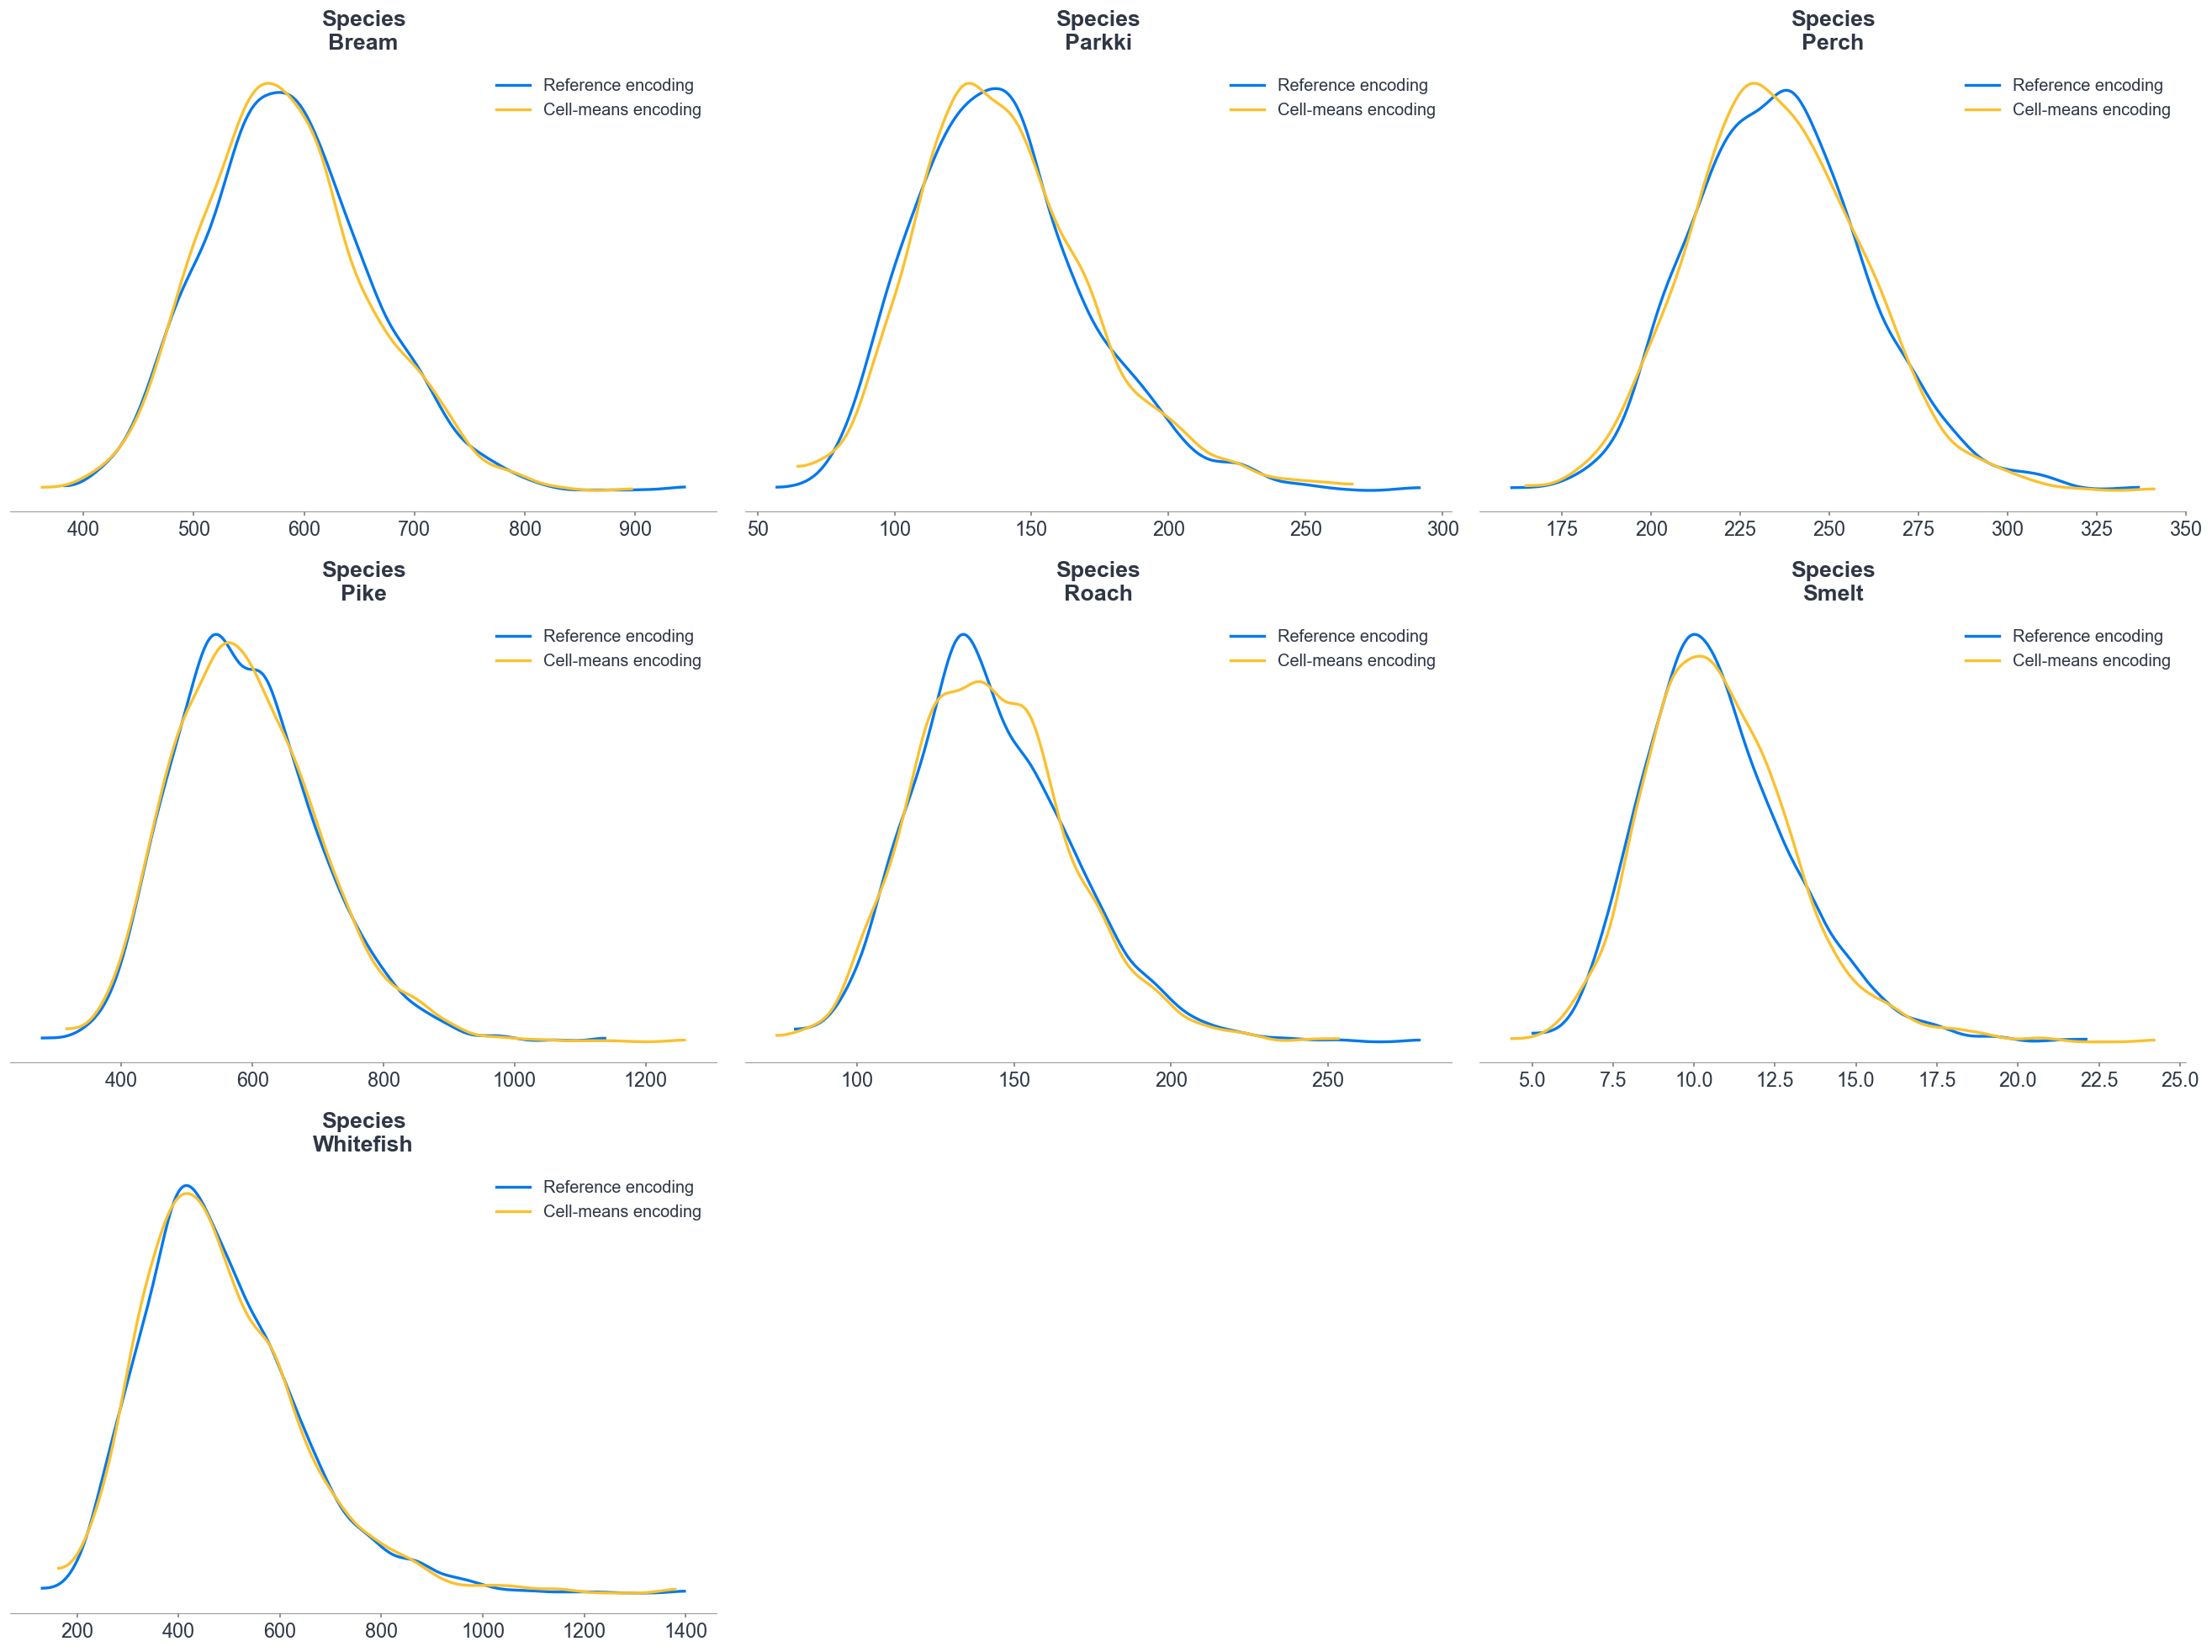

In [36]:
axes = az.plot_posterior(
    species_mean,
    hdi_prob="hide",
    point_estimate=None,
    transform=np.exp,
    lw=2,
    label="Reference encoding"
)

az.plot_posterior(
    idata_c2.posterior["Species"],
    hdi_prob="hide", 
    point_estimate=None,
    transform=np.exp, 
    ax=axes, 
    color="C1",
    lw=2,
    label="Cell-means encoding"
)

plt.tight_layout()

* We can plot the posteriors from both models
* In both cases, we obtain the same prediction for all the species
* This is because they're the same models!
* Note: The exp transform is because we're modeling the response in the log scale

## Section Recap

* Bambi handles categorical variables out of the box
    * There's no need to perform any manual work
    * Interpreting results require us to be familiar with model parametrization
* Categorical variables require more care
    * Restrictions are applied to make the model identifiable
    * Bambi handle them automatically for us
* Equivalent models can be expressed in different ways
    * `log(Weight) ~ 1 + Species` and `log(Weight) ~ 0 + Species` are equivalent
    * The interpretation of parameters differ
    * Pick the one that suits your needs
* ...?

# Section 70: Understanding encodings

**NOTE:** I got excited writing and I covered most (if not all) concepts in Section 60. But it looks like a very long section. So maybe it's sensible to split Section 60 in two, and make the second part the new Section 70, showing the model with cell means encoding (y ~ 0 + Species)

## Section Recap

# Section 80: The full model

## The model

$$
\begin{aligned}
\beta_{0,j} & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\beta_{1,j} & \sim \text{Normal}(0, \sigma_{\beta_1}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\mu_{i, j} & = \beta_{0,j} + \beta_{1,j} \log{(\text{Length}_{i, j})} \\
\log{(\text{Weight}_{i,j})} & \sim \text{Normal}(\mu_{i, j}, \sigma)
\end{aligned}
$$

for $j=1, \cdots, 7$.

* For each species, we want a slope for `log(Length)`

## The model in Bambi

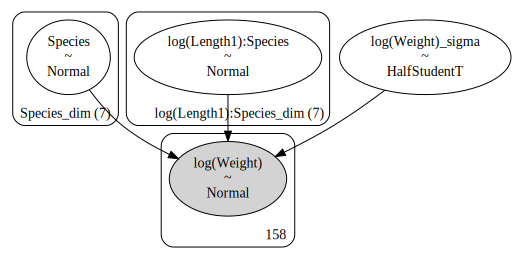

In [37]:
model_full = bmb.Model("log(Weight) ~ 0 + Species + log(Length1):Species", data)
model_full.build()
model_full.graph()

In [38]:
idata_full = model_full.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Length1):Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.


## The interaction operator `:`

* We used a new thing, the interaction operator `:`
* `numeric:categoric` means we want a `numeric` slope for every category in `categoric`
* In our problem, `log(Length1):Species` means there's a `log(Length1)` slope for every species in `Species`

## Mapping the formula to coefficients

<center>
  <img src="imgs/formula_0_plus_length_plus_length_species.png" style="width:80%"; />
</center>

## The posterior

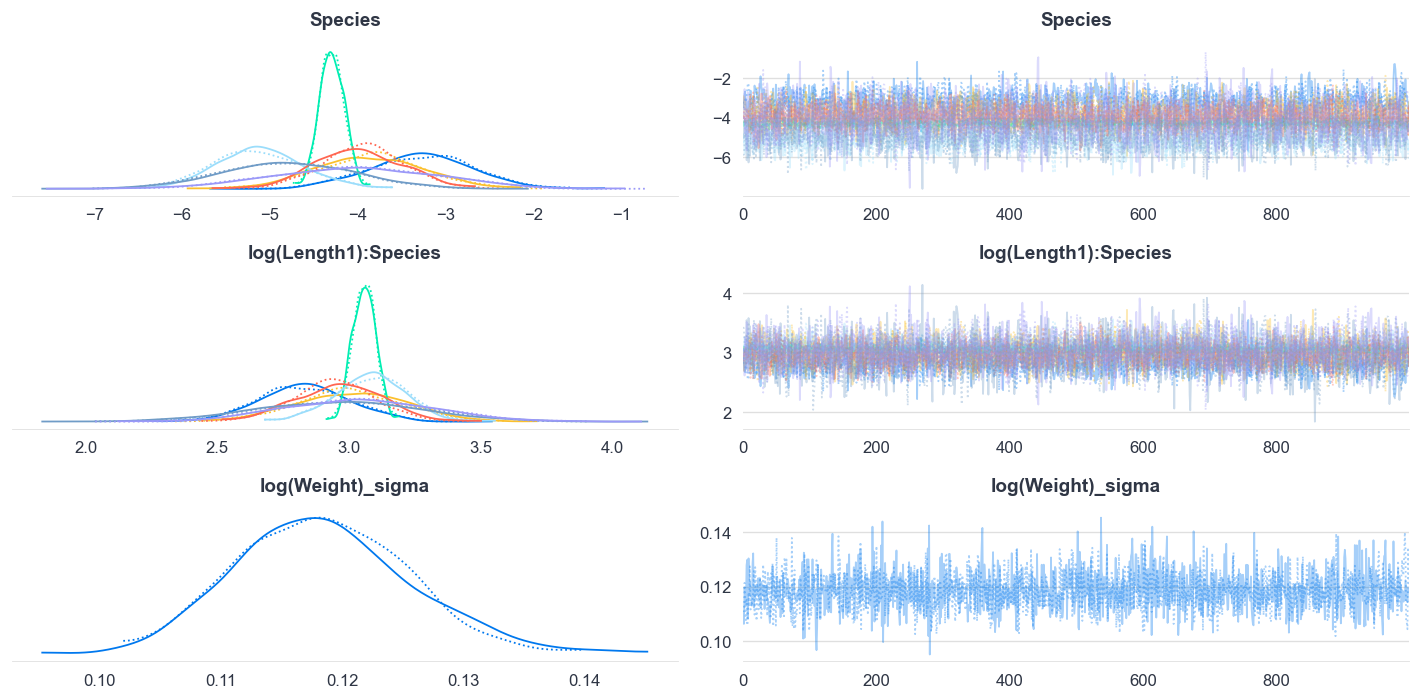

In [39]:
az.plot_trace(idata_full)
plt.tight_layout()

## An old friend

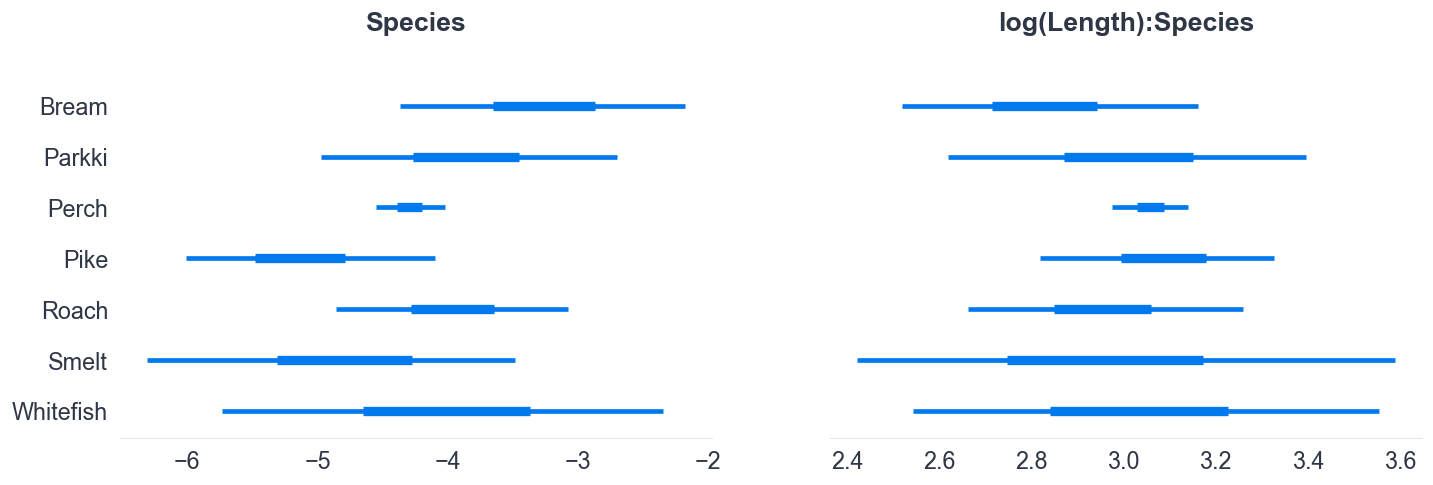

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4.2), sharey=True)
az.plot_forest(idata_full, var_names="Species", combined=True, linewidth=2.8, ax=axes[0])
az.plot_forest(idata_full, var_names="log(Length1):Species", combined=True, linewidth=2.8, ax=axes[1])
axes[0].set(title="Species", yticklabels=reversed(np.unique(data["Species"])))
axes[1].set(title="log(Length):Species");

* Does this remind you any othe plot we have created in the past?

## Section Recap

## Section 90: Predictions

## Train-test split

In [41]:
df_test = data.sample(frac=0.1, random_state=1234).sort_index()
df_train = data.loc[data.index.difference(df_test.index)]
df_test.shape, df_train.shape

((16, 9), (142, 9))

## Create the model

* Just like any other Bambi model
* No need to use `pm.MutableData`

In [42]:
model = bmb.Model("log(Weight) ~ 0 + Species + log(Length1):Species", df_train)
model

Formula: log(Weight) ~ 0 + Species + log(Length1):Species
Family name: Gaussian
Link: identity
Observations: 142
Priors:
  Common-level effects
    Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [ 7.9067 13.5588  6.9837 10.1763  9.9293 11.4552 17.9235])
    log(Length1):Species ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [2.3222 4.6028 2.1659 2.725  3.2592 4.7218 5.4423])

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 1.3214)

Notice the number of observations changed

## Fit model

In [43]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Species, log(Length1):Species, log(Weight)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.


## Predictions: Mean-level

How to get predictions for $E(y) = \mu$

In [44]:
model.predict(idata, data=df_test)

In [45]:
idata.posterior["log(Weight)_mean"]

<xarray.DataArray 'log(Weight)_mean' (chain: 2, draw: 1000, log(Weight)_obs: 16)>
array([[[6.03797586, 6.61470972, 6.68476874, ..., 6.4824707 ,
         6.74003943, 2.05102154],
        [6.00000606, 6.56904812, 6.63817277, ..., 6.47214087,
         6.72899726, 2.00577325],
        [5.99703234, 6.54710406, 6.61392427, ..., 6.4927119 ,
         6.75060789, 2.10514256],
        ...,
        [6.02645   , 6.55907744, 6.6237786 , ..., 6.44801005,
         6.69931408, 2.02141667],
        [6.01372495, 6.53559147, 6.59898545, ..., 6.46710806,
         6.72046541, 2.00989725],
        [6.05583695, 6.56560777, 6.62753242, ..., 6.48062021,
         6.7354727 , 2.01072568]],

       [[6.02493658, 6.54580811, 6.60908122, ..., 6.49500933,
         6.75365325, 2.10145284],
        [5.99254092, 6.65235531, 6.73250657, ..., 6.53387386,
         6.79900365, 2.07444242],
        [6.00212795, 6.62364395, 6.69914289, ..., 6.47385021,
         6.73580276, 2.01211952],
        ...,
        [5.97255042, 6.53515973, 6.60350296, ..., 6.4799404 ,
         6.73838144, 2.08512005],
        [6.03859015, 6.59866445, 6.66669974, ..., 6.50779977,
         6.77200783, 2.02981791],
        [6.06892394, 6.62625607, 6.69395826, ..., 6.50196296,
         6.76501688, 2.00766163]]])
Coordinates:
  * chain            (chain) int64 0 1
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * log(Weight)_obs  (log(Weight)_obs) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15

* There's no need to do any kind indexing and  `pm.set_data` wizardy
* Just pass a data frame with the out of sample observations, Bambi will handle all the rest
* By default, it obtains the posterior for the mean response

## Predictions: Individual-level

How to get predictions for a new observation $y$

In [46]:
model.predict(idata, data=df_test, kind="pps")

In [47]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:          (chain: 2, draw: 1000, log(Weight)_obs: 16)
Coordinates:
  * chain            (chain) int64 0 1
  * draw             (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * log(Weight)_obs  (log(Weight)_obs) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
Data variables:
    log(Weight)      (chain, draw, log(Weight)_obs) float64 6.25 6.811 ... 1.998
Attributes:
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1

## Visualize individual predictions

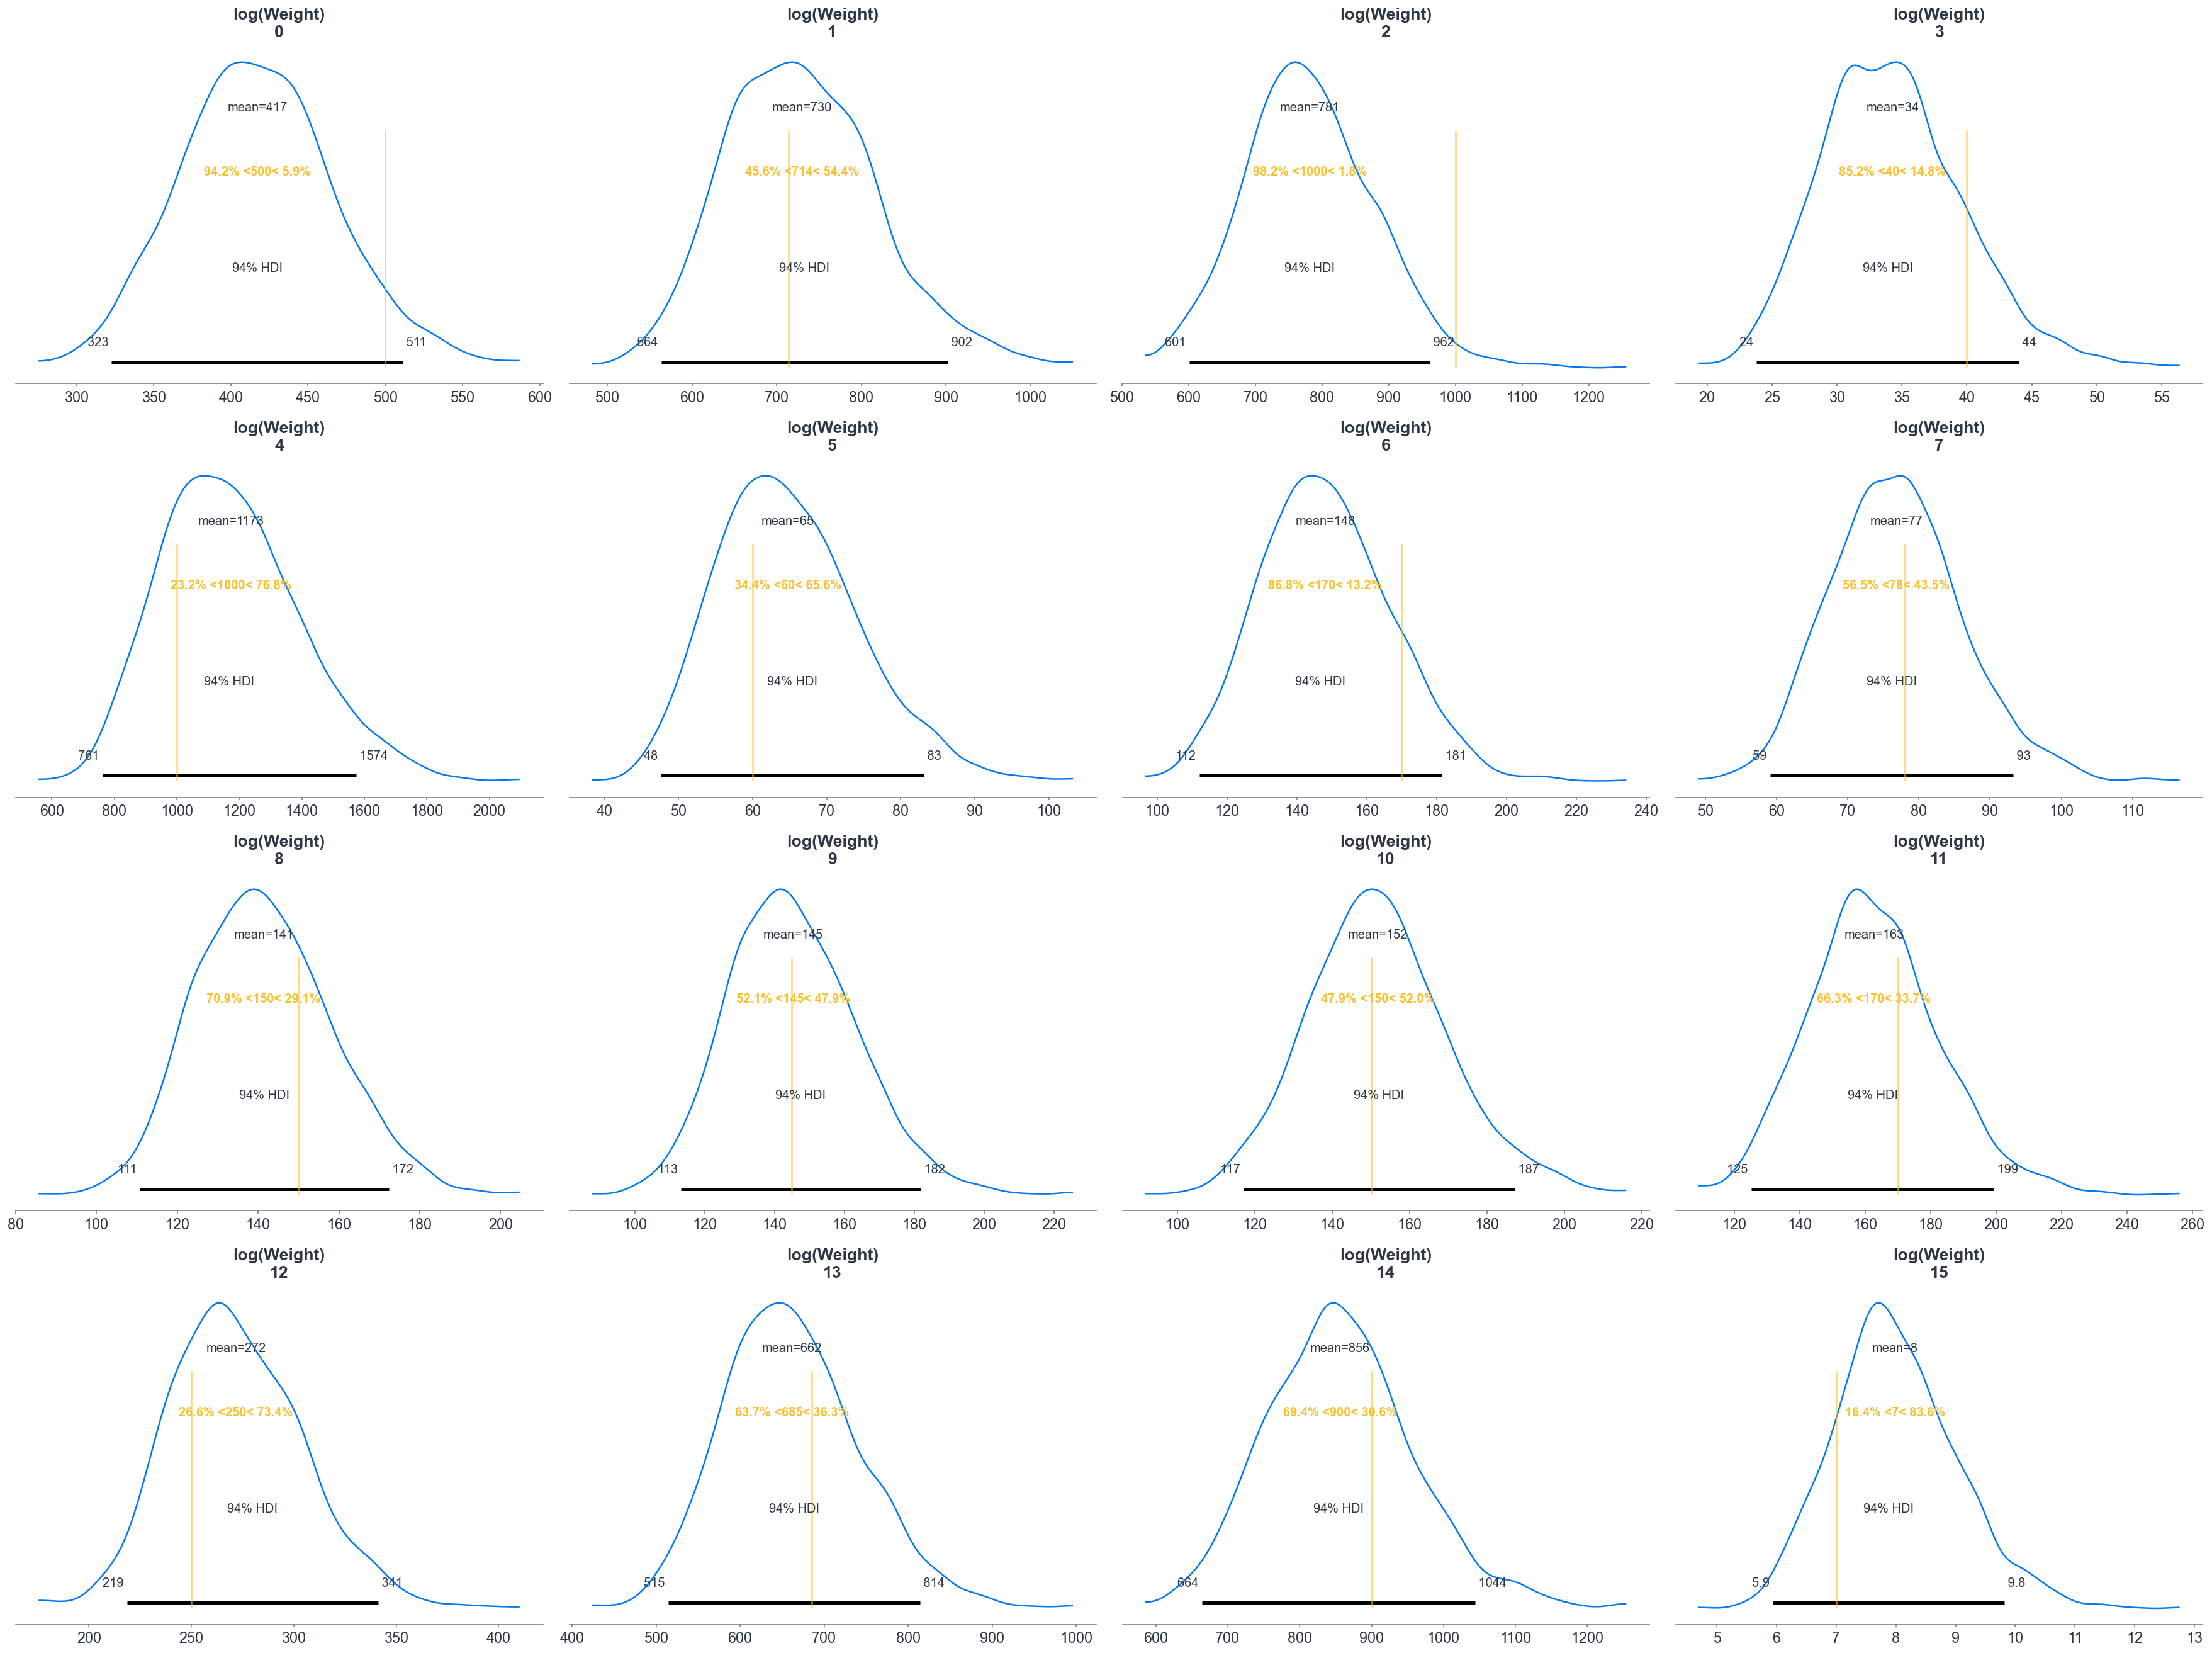

In [48]:
axes = az.plot_posterior(
    idata.posterior_predictive["log(Weight)"],
    ref_val=df_test["Weight"].tolist(),
    transform=np.exp,
)
plt.tight_layout()

* The same results we got with PyMC!
* But much easier

## Section Recap

* You don't need to worry about encoding details when computing predictions
    * Bambi handles all of them
* Get the same results than with PyMC
    * But much faster, with a small fraction of the work

## Section 100: End to end analysis with Bambi

You've now a matter of fitting things, with straight lines at least. In the next lessons we're going to move past straight lines, but before we get there lets do one last lap through the whole workflow with everything we learned, real quickly. In the future when youre trying to remmeber howt o fit regression fast, this will be the whole video you need. 

* Model specification
* Explore priors
* Explore prior predictive distribution
* Change priors?
* Update model
* Explore model again
* Fit model
* Explore posteriors
* Diagnose posteriors
* Show fitted curve
* Predict weigth for new observations

## Section Recap

# Appendix: Priors in Bambi